In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from datetime import datetime
from datetime import date

## Importing CSVs

In [2]:
dfMovies = pd.read_csv(
    "content/IMDb movies w top_actor, top_actor_gender.csv",
    dtype={"year": str, "budget": str},
    sep="\t",
)
dfNames = pd.read_csv("content/IMDb names.csv")
dfRatings = pd.read_csv("content/IMDb ratings.csv")
dfTitlePrincipals = pd.read_csv("content/IMDb title_principals.csv")

In [3]:
dfMovies.shape

(85220, 24)

In [4]:
# Pick the columns from each of the datasets that should be used to train the ML algorithms
dfMovies = dfMovies[
    [
        "imdb_title_id",
        "title",
        "year",
        "genre",
        "duration",
        "country",
        "language",
        "director",
        "writer",
        "production_company",
        "budget",
        "top_actor",
        "top_actor_gender",
        "date_published"
    ]
]

dfRatings = dfRatings[
    ["imdb_title_id", "weighted_average_vote"]
]  # come back to this and include age groups/male/female votes
dfTitlePrincipals = dfTitlePrincipals[
    ["imdb_title_id", "ordering", "imdb_name_id"]
]  # should we get category? "actress"/"actor" (dont know if its necessary)

dfMovies = pd.merge(dfMovies, dfRatings, on=["imdb_title_id"])

dfMovies.shape

(85220, 15)

## Merging dfNames with dfMovies

In [5]:
dfNames = dfNames.drop_duplicates("name")

dfMovies_Names = pd.merge(
    dfMovies,
    dfNames[
        [
            "name",
            "height",
            "divorces",
            "date_of_birth",
            "date_of_death",
        ]
    ],
    left_on=["top_actor"],
    right_on=["name"]
).drop(columns=["name"])

In [6]:
dfMovies_Names.shape

(85220, 19)

In [7]:
dfMovies_Names.dtypes

imdb_title_id             object
title                     object
year                      object
genre                     object
duration                   int64
country                   object
language                  object
director                  object
writer                    object
production_company        object
budget                    object
top_actor                 object
top_actor_gender          object
date_published            object
weighted_average_vote    float64
height                   float64
divorces                   int64
date_of_birth             object
date_of_death             object
dtype: object

## Adding `actor_age` and `actor_age_at_release` to dfMovies

In [8]:
def calc_age_at_release(row):
    try:
        born = datetime.strptime(row["date_of_birth"], "%Y-%m-%d").date()
        released = datetime.strptime(row["date_published"], "%Y-%m-%d").date()
        
        age = released.year - born.year
        
        return age if age > 0 and age < 120 else None
    except:
        return None

Two functions to calculate the top actors age and the top actor age when the movie is released.

In [9]:
dfMovies_Names["actor_age_at_release"] = dfMovies_Names.apply(calc_age_at_release, axis=1)

In [10]:
dfMovies_Names["actor_age_at_release"].describe()

count    64295.000000
mean        39.167198
std         13.095969
min          1.000000
25%         30.000000
50%         37.000000
75%         47.000000
max        119.000000
Name: actor_age_at_release, dtype: float64

In [11]:
dfMovies_Names = dfMovies_Names.drop(columns=["date_of_birth", "date_of_death", "date_published"])

Dropping the features used to calculate the new features.

In [12]:
dfMovies_Names.dropna().shape

(15688, 17)

In [13]:
pd.DataFrame(dfMovies_Names.dtypes)

,0
imdb_title_id,object
title,object
year,object
genre,object
duration,int64
country,object
language,object
director,object
writer,object
production_company,object


## Binning `actor_age_at_release`

In [14]:
dfMovies_Names["actor_age_at_release"], bins = pd.cut(
    dfMovies_Names["actor_age_at_release"],
    4,
    labels=["child", "teenager", "adult", "old"],
    retbins=True,
)

In [15]:
bins

array([  0.882,  30.5  ,  60.   ,  89.5  , 119.   ])

## Casting `year` and `budget` features

In [16]:
dfMovies_Names["year"] = dfMovies_Names["year"].astype(str).str.extract("(\d+)")
dfMovies_Names["budget"] = dfMovies_Names["budget"].astype(str).str.extract("(\d+)")

dfMovies_Names.year = pd.to_numeric(dfMovies_Names.year, errors="coerce").astype("Int64")
dfMovies_Names.budget = pd.to_numeric(dfMovies_Names.budget, errors="coerce").astype("Int64")

In [17]:
dfMovies_Names.dtypes

imdb_title_id              object
title                      object
year                        Int64
genre                      object
duration                    int64
country                    object
language                   object
director                   object
writer                     object
production_company         object
budget                      Int64
top_actor                  object
top_actor_gender           object
weighted_average_vote     float64
height                    float64
divorces                    int64
actor_age_at_release     category
dtype: object

## Removing nulls and renaming

In [18]:
dfMovies_Names = dfMovies_Names.dropna()
df = dfMovies_Names

In [19]:
df.shape

(15688, 17)

Dropping any rows with `NaN`.

## Scaling Continuous Features

In [20]:
to_scale = [
    "duration",
    "budget",
    "height",
    "divorces"
]

In [21]:
from sklearn.preprocessing import StandardScaler

scaler = StandardScaler()

for col in to_scale:
    print(f"scaling {col}...")
    df[[col]] = scaler.fit_transform(df[[col]])

scaling duration...
scaling budget...
scaling height...
scaling divorces...


## Encoding Functions

In [22]:
def encode_normal(df, col):
    return pd.get_dummies(df[col])

In [23]:
def other_col(row):
    if row.sum() == 0:
        return 1
    return 0

In [24]:
def encode_top_n(df, col, top):
    genre_encoded_df = pd.DataFrame()
    
    top_cat = pd.Index([f"{col}_{x}" for x in df[col].value_counts().index])[:top]
    genre_encoded_df = pd.get_dummies(df[col], prefix=col)[top_cat]

    genre_encoded_df["other_" + col] = genre_encoded_df.apply(other_col, axis=1)

    return genre_encoded_df

`encode_normal` returns the encoded column in a DataFrame.

`encode_top_n` return the top `n` most frequent values encoded in a DataFrame with an `other_` column for all the other values.

## Analyzing Categorical Features

### `genre`

In [25]:
df["genre"].value_counts()

Drama                          1147
Comedy                          812
Comedy, Drama                   590
Drama, Romance                  547
Comedy, Drama, Romance          545
                               ... 
Action, Comedy, Western           1
Adventure, Comedy, Thriller       1
Drama, Thriller, Mystery          1
Crime, Horror, Sci-Fi             1
Adventure, History, Western       1
Name: genre, Length: 666, dtype: int64

It looks like there are a significant number of movies that classify as the same genre.

In [26]:
genre_1_freq = (
    df["genre"].value_counts().where(df["genre"].value_counts() == 1).dropna()
)

print(genre_1_freq.shape)

genre_over_100_freq = (
    df["genre"].value_counts().where(df["genre"].value_counts() > 100).dropna()
)

print(genre_over_100_freq.shape)
print(genre_over_100_freq.sum())
print(f"{(genre_over_100_freq.sum()) / (df.shape[0])*100:.0f}%")

(223,)
(30,)
8584.0
55%


Specifically, there are 227 genres that only classify *one movie*. However there are 33 genres that classify over 100 movies. In total, those 33 genres account for 9,619 movies, which is over 50% of the movies in our dataset.

Therefore, it's probably safe to just OneHotEncode the existing values in `genres`.

Similar analysis of the following features are below.

### Other categorical features

In [27]:
to_encode = [
    "genre",
    "country",
    "language",
    "director",
    "writer",
    "production_company",
    "top_actor"
]


GENRE --------------------------------------------
Drama                          1147
Comedy                          812
Comedy, Drama                   590
Drama, Romance                  547
Comedy, Drama, Romance          545
                               ... 
Action, Comedy, Western           1
Adventure, Comedy, Thriller       1
Drama, Thriller, Mystery          1
Crime, Horror, Sci-Fi             1
Adventure, History, Western       1
Name: genre, Length: 666, dtype: int64

num of categories with 1 movie: 223

num of categories with over 100 movies: 30 which accounts for 8584

num of categories with > 100 movie: 30
accounts for 8584 or 55% of the dataset

COUNTRY --------------------------------------------
USA                                  7902
UK                                    612
India                                 470
Canada                                347
UK, USA                               303
                                     ... 
UK, Spain, Germany, It

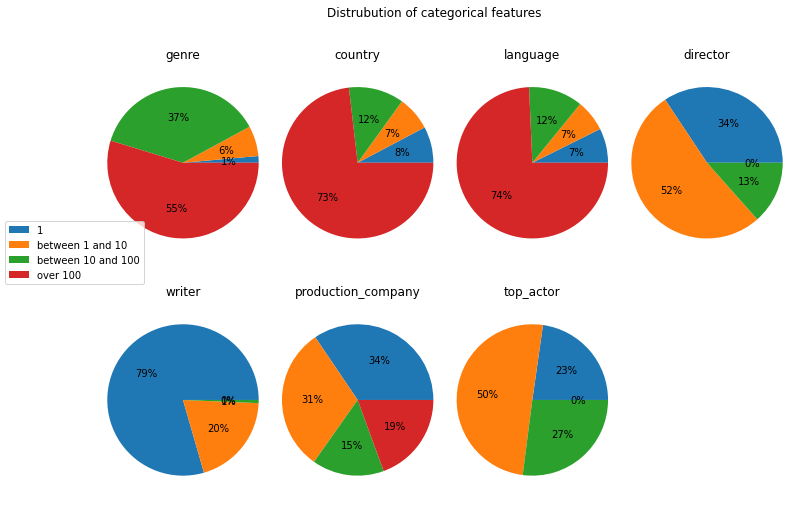

In [28]:
rows = df.shape[0]
labels = ["1", "between 1 and 10", "between 10 and 100", "over 100"]

fig, axs = plt.subplots(2, 4)
fig.set_size_inches(12, 8)
plt.suptitle("Distrubution of categorical features")

axs = axs.flatten()

for i, col in enumerate(to_encode):
    data = []
    
    print(f"\n{col.upper()} --------------------------------------------")
    vc = df[col].value_counts()
    print(vc)

    filtered = vc.where(vc == 1).dropna()
    data.append((filtered.sum() / rows) * 100)

    print(f"\nnum of categories with 1 movie: {filtered.shape[0]}")

    filtered = vc.where((vc > 1) & (vc <= 10)).dropna()
    data.append((filtered.sum() / rows) * 100)

    filtered = vc.where((vc > 10) & (vc <= 100)).dropna()
    data.append((filtered.sum() / rows) * 100)

    filtered = vc.where(vc > 100).dropna()
    
    data.append((filtered.sum() / rows) * 100)

    print(
        f"\nnum of categories with over 100 movies: {filtered.shape[0]} which accounts for {filtered.sum():.0f}"
    )

    axs[i].axis("equal")

    patches = axs[i].pie(data, autopct="%.0f%%", radius=1.3)[0]
    axs[i].set(ylabel='', title=col, aspect='equal')

    print(f"\nnum of categories with > 100 movie: {filtered.shape[0]}")
    print(
        f"accounts for {filtered.sum():.0f} or {(filtered.sum()/rows)*100:.0f}% of the dataset"
    )

axs[7].remove()
fig.legend(patches, labels, loc="center left")

In [29]:
df.dtypes

imdb_title_id              object
title                      object
year                        Int64
genre                      object
duration                  float64
country                    object
language                   object
director                   object
writer                     object
production_company         object
budget                    float64
top_actor                  object
top_actor_gender           object
weighted_average_vote     float64
height                    float64
divorces                  float64
actor_age_at_release     category
dtype: object

## Encoding Categorical Columns

In [30]:
df = dfMovies_Names

In [31]:
for col in to_encode:
    print(f"encoding {col}...")
    
    vc = df[col].value_counts()
    filtered = vc.where(vc > 100).dropna().sum()
    
    if (filtered / rows) > 0.5:
        df = df.join(encode_top_n(df, col, 100))
        
    df = df.drop(columns=[col])
    
    print(df.dropna().shape)

encoding genre...
(15688, 117)
encoding country...
(15688, 217)
encoding language...
(15688, 317)
encoding director...
(15688, 316)
encoding writer...
(15688, 315)
encoding production_company...
(15688, 314)
encoding top_actor...
(15688, 313)


# To Do:
- Z-score scale the continuous values

## Encoding `year`

In [32]:
to_encode_normal = [
    "year",
    "actor_age_at_release",
    "top_actor_gender"
]

In [33]:
for col in to_encode_normal:
    df = df.join(encode_normal(df, col))
    df = df.drop(columns=[col])
    print(df.dropna().shape)

(15688, 420)
(15688, 423)
(15688, 424)


## Output to CSV

In [34]:
df.shape

(15688, 424)

In [35]:
df.to_csv("content/combined_data_all_encoded_500.csv", index=False)